# See get_elmo_embeddings.ipynb in Colab Notebook folder
Due to computational limitations and Tensorflow version conflict this process was divided into 2 parts.

In [1]:
import json
from bs4 import BeautifulSoup
from pprint import pprint
import pandas as pd
import re


def clean_text(raw_text: str):
    if raw_text is None:
        return ''

    soup = BeautifulSoup(raw_text, features="html.parser")
    raw_text = soup.get_text()
    raw_text = raw_text.replace('\n', ' ').replace('\xa0', ' ')
    return raw_text


def read_json_as_df(path: str) -> pd.DataFrame:
    json_data = []

    with open(path, 'r', encoding='utf-8') as file:

        for line in file:
            data = json.loads(line)
            json_data.append([clean_text(data['post'].get('body', None)),
                              data['priority']])

    df = pd.DataFrame(data=json_data, columns=('text', 'priority'))

    return df

In [2]:
from sklearn.metrics import classification_report, f1_score


def print_results(true_labels, predictions):
    
    print('\n\033[1m-----------Full Classification Report-----------\033[0m\n')
    print(classification_report(true_labels, predictions))
    
    
    print("\n\033[1m------OFFICIAL - ignoring 'green' priority------\033[0m\n")
    print('\tMacro avgd f1 score: ', f1_score(true_labels, predictions, labels=['escalate', 'red', 'amber'], average='macro'))
    
    
    print("\n\033[1m----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----\033[0m\n")
    def map_flagged(label):
        if label in ['escalate', 'red', 'amber']:
            return 'flagged'
        elif label == 'green':
            return 'green'

    flagged_ytest = list(map(map_flagged, true_labels))
    flagged_predictions = list(map(map_flagged, predictions))

    print(classification_report(flagged_ytest, flagged_predictions))
    
    print("\n\033[1m----URGENT - 'red + escalate' as urgent vs 'amber + green' as non_urgent-----\033[0m\n")
    def map_urgent(label):
        if label in ['escalate', 'red']:
            return 'urgent'
        elif label in ['green', 'amber']:
            return 'non-urgent'

    urgent_ytest = list(map(map_urgent, true_labels))
    urgent_predictions = list(map(map_urgent, predictions))

    print(classification_report(urgent_ytest, urgent_predictions))


In [3]:
import pickle

train_embeds = pickle.load(open('../Data/elmo_train.pkl', 'rb'))
test_embeds = pickle.load(open('../Data/elmo_test.pkl', 'rb'))

In [4]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

In [5]:
train_df = read_json_as_df('../Data/combined-train.json')
test_df = read_json_as_df('../Data/combined-test.json')

In [6]:
train_df.text = train_df.text.str.strip()
train_df = train_df[train_df.text != '']

# test_df.text = test_df.text.str.strip()
test_df = test_df[test_df.text != '']

In [7]:
train_embeds.shape

(6401, 1024)

In [8]:
train_df.shape

(6401, 2)

In [9]:
train_embeds[0].shape

(1024,)

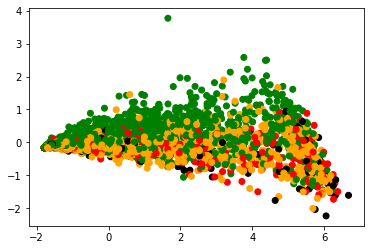

In [10]:
pca = PCA(n_components=2).fit(train_embeds)

features_2d = pca.transform(train_embeds)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=train_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

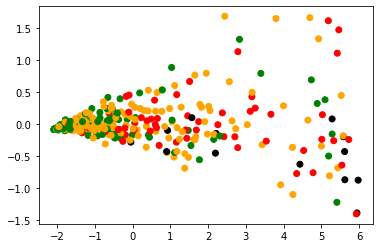

In [11]:
pca = PCA(n_components=2).fit(test_embeds)

features_2d = pca.transform(test_embeds)

plt.scatter(features_2d[:, 0], features_2d[:, 1], c=test_df.priority.map({'green': 'green', 
                                                                           'amber': 'orange',
                                                                           'red': 'red',
                                                                           'escalate': 'black'}))

In [12]:
%%time

params = {'C': scipy.stats.expon(scale=10), 
          'gamma': scipy.stats.expon(scale=.1), 
          'kernel': ['rbf'], 
          'class_weight':['balanced'],
          'cache_size': [1024]}

clf = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         n_jobs=10,
                         scoring='f1_macro',
                         cv=5,
                         n_iter=50)

svc_searched_clf = clf.fit(train_embeds, train_df.priority)

print('Best Params:', svc_searched_clf.best_params_, '\n')
print('Best macro avg F1 score:', svc_searched_clf.best_score_, '\n')
print(svc_searched_clf.best_estimator_, '\n')

Best Params: {'C': 5.281739099659536, 'cache_size': 1024, 'class_weight': 'balanced', 'gamma': 0.06954626248763725, 'kernel': 'rbf'} 

Best macro avg F1 score: 0.47993450462693055 

SVC(C=5.281739099659536, cache_size=1024, class_weight='balanced',
    gamma=0.06954626248763725) 

Wall time: 47min 16s


In [13]:
predicted_priority = svc_searched_clf.predict(test_embeds)    
print_results(test_df.priority, predicted_priority)


-----------Full Classification Report-----------

              precision    recall  f1-score   support

       amber       0.68      0.62      0.65       154
    escalate       0.32      0.41      0.36        17
       green       0.71      0.87      0.78       158
         red       0.68      0.39      0.50        69

    accuracy                           0.67       398
   macro avg       0.59      0.57      0.57       398
weighted avg       0.67      0.67      0.66       398


------OFFICIAL - ignoring 'green' priority------

	Macro avgd f1 score:  0.5010119505532349

----FLAGGED - 'crisis + red + amber' as flagged vs 'green'----

              precision    recall  f1-score   support

     flagged       0.90      0.76      0.82       240
       green       0.71      0.87      0.78       158

    accuracy                           0.80       398
   macro avg       0.80      0.81      0.80       398
weighted avg       0.82      0.80      0.81       398


----URGENT - 'red + escalate